# Recurrent Group-Testing as an alternative to Social Distancing for containing the COVID-19 pandemic

If social distancing orders are to be relaxed in the near future, it is imperative to have an alternative strategy for mitigating the spread of COVID-19.

This notebook studies the extent to which recurrent group-testing can be used as an alternative to social distancing.

The recurrent group-testing procedure works as follows:
* We consider a city with $N$ households.  Each household contains $M$ individuals.  $M$ and $N$ are configurable parameters.  There is no travel in or out of the city for the length of the simulation.
* A test day occurs once every $D$ days. $D$ is a configurable parameter.  
* On each test day, every citizen participates in a group test with probability $P$.  $P$ is a configurable parameter.
* The (randomly selected) group-test participants are allocated into buckets of max-size $S$.  $S$ is a configurable parameter. Household members are always allocated to the same group.
* A single test is used to check for the presence of COVID-19 in each group.  
    * A parameter $FNR$ models the false-negative rate for an individual. $FNR$ is configurable.
    * The probability that the test produces a false negative for a group with $S$ individuals is assumed to be 
        $$ 1 - FNR^S. $$
* When a group test does not detect the presence of COVID-19, the participants have social distancing restrictions lifted.  The rate of spread of the disease across the population of non-social-distancing citizens is a configurable parameter.
* When a group test does return positive then all of the citizens must **remain in complete isolation** until the next test day period.  This is a much more severe assumption that current social distancing guidelines. We say these participants are quarantined.  When an individual is quarantined we assume that all individuals in the household become quarantined. If a quarantined individual is infected, he or she can only spread the disease to members of his or her household.  This spread occurs with a configurable probability $SAR$.
    * **Note:** The existence of this possibility would create a strong **disincentive** for citizens to participate in the test.
* The disease ends in an individual after a configurable number of days.  
* The simulation assumes that every individual begins in the strict quarantine state

Summary of parameters:
 * $N$: Number of households
 * $M$: Household size
 * $D$: Test day frequency
 * $P$: Probability each individual participates in a group test
 * $S$: Size of group for each group test
 * $FNR$: False-negative rate for an individual.  If $K$ out of the $S$ individuals in the group are infected, then the group test produces a false-negative with probability $$1-FNR^K.$$ 
 * $SAR$: Secondary attack rate, i.e. probability disease spreads within a household on each day
 * $\alpha$: The rate-of-spread of the disease for the population of non-quarantined individuals
 * $d_0$: The length of the disease
 * $p$: fatality percent
 

For a particular instantiation of each of the above parameters, the simulation looks at the following metrics.
As a function of time:
* what is the total fraction of the population that has been infected by the pandemic?
* what is the total fraction of the population that has died from the pandemic?
* what is the fraction of population that is not in quarantine?
* what is the resource usage (in terms of total number of tests) required to supply the entire test


In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
from population import Population
from group_testing import SymptomaticIndividualTest, ThreeStageHierarchicalTest
from simulation import Simulation

def initiate_simulation():
    if not test_only_symptomatic_individuals:
        test = ThreeStageHierarchicalTest(large_group_size,
                                                small_group_size,
                                         group_test_participation_rate,
                                         outer_false_negative_rate,
                                         inner_false_negative_rate,
                                         )
    else:
        test = SymptomaticIndividualTest(inner_false_negative_rate)

    population = Population(n_households,
                            household_size,
                            initial_prevalence,
                            disease_length,
                            time_until_symptomatic,
                            non_quarantine_alpha,
                            daily_secondary_attack_rate,
                            fatality_pct,
                            daily_outside_infection_pct,
                            outside_symptomatic_prob)


    simulation = Simulation(population, test, test_day_frequency, test_latency, halt_operations_if_case_detected)
    return simulation

def summarize(simulation):
    print("Total number of tests performed over {} days: {}".format(simulation.current_day,
                                                                   simulation.cumulative_tests_to_date))
    days = range(simulation.current_day)
    cumulative_infected_pct = [simulation.recorded_data[day]['cumulative_infected_fraction'] for day in days]
    within_population_infected_pct = [simulation.recorded_data[day]['cumulative_infected_within_population'] for day in days]
    quarantine_pct = [simulation.recorded_data[day]['in_quarantine_fraction'] for day in days]
    infected_pct = [simulation.recorded_data[day]['infected_fraction'] for day in days]
    plt.figure(figsize=(10,6))
    plt.ylim((-0.1,1.1))
    plt.plot(days, cumulative_infected_pct, label="Cumulative Fraction of Population Infected")
    plt.plot(days, quarantine_pct, label="Fraction of Population in Quarantine")
    plt.plot(days, within_population_infected_pct, label="Cumulative Fraction of Population Infected due to Within-Community Spread")
    plt.plot(days, infected_pct, label="Fraction of Population Infected")
    plt.legend(loc='best')
    plt.show()
    
    cumulative_tests = [simulation.recorded_data[day]['cumulative_tests_to_date'] for day in days]
    plt.figure(figsize=(10,6))
    plt.plot(days, cumulative_tests, label='Cumulative Tests to Date')
    plt.legend(loc='best')
    plt.show()
    
    if simulation.halt_operations_if_case_detected:
        days_halted = [simulation.recorded_data[day]['cumulative_days_halted'] for day in days]
        plt.figure(figsize=(10,6))
        plt.plot(days, days_halted, label="Cumulative Days Halted due to Detected Cases")
        plt.legend(loc='best')
        plt.show()
def run(simulation, number_of_days):
    for _ in range(number_of_days):
        simulation.step()

In [5]:

# Population parameters

n_households = 100

household_size = 1

daily_outside_infection_pct = 0.001

initial_prevalence = 0.05

disease_length = 14

R0 = 7.5

non_quarantine_alpha = R0 ** (1 / disease_length)

print("alpha = {:.2f}".format(non_quarantine_alpha))

daily_secondary_attack_rate = 0.5

fatality_pct = 0.02

# Group test parameters

large_group_size = 25
small_group_size = 5

group_test_participation_rate = 0.7

outer_false_negative_rate = 0.3

inner_false_negative_rate = 0.1

test_day_frequency = 5

test_latency = 2

halt_operations_if_case_detected = True

test_only_symptomatic_individuals = True

outside_symptomatic_prob = 0.1

time_until_symptomatic = 7


alpha = 1.15


Total number of tests performed over 90 days: 244


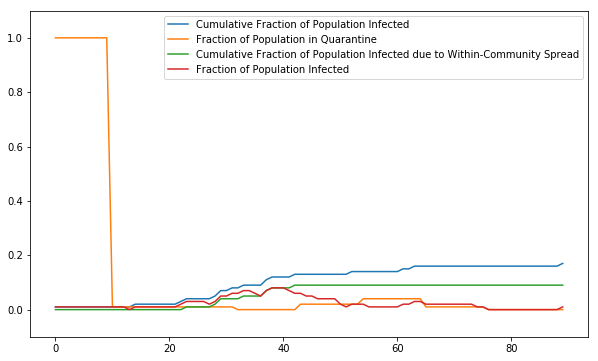

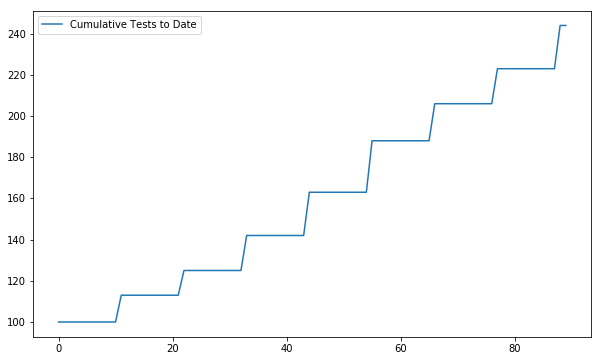

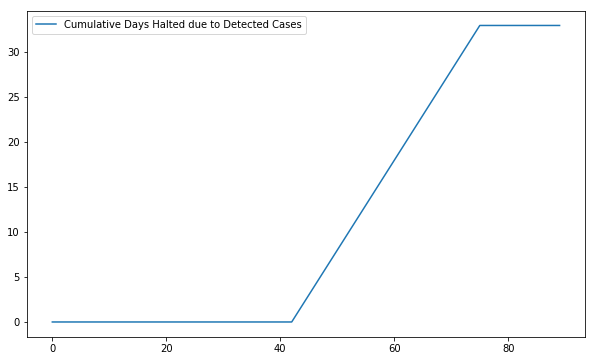

In [6]:
simulation = initiate_simulation()
run(simulation, number_of_days=90)
summarize(simulation)

In [7]:
group_test_participation_rate = 0.99
R0 = 2.5

Total number of tests performed over 60 days: 197


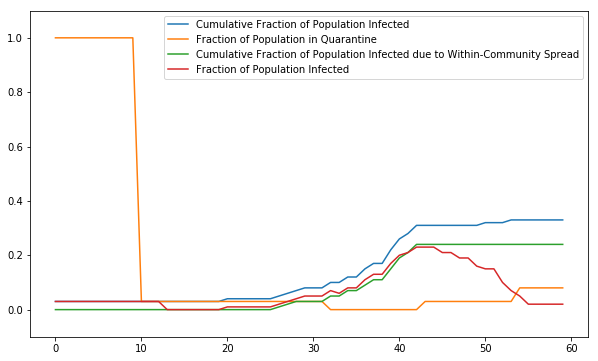

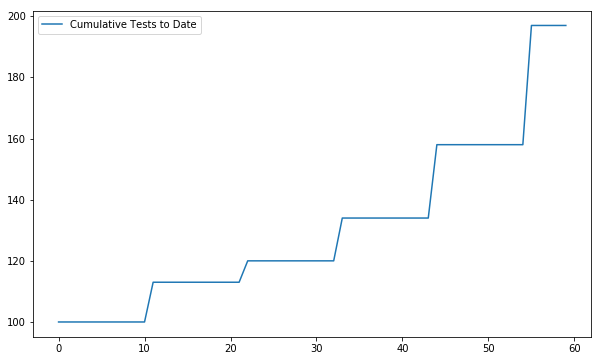

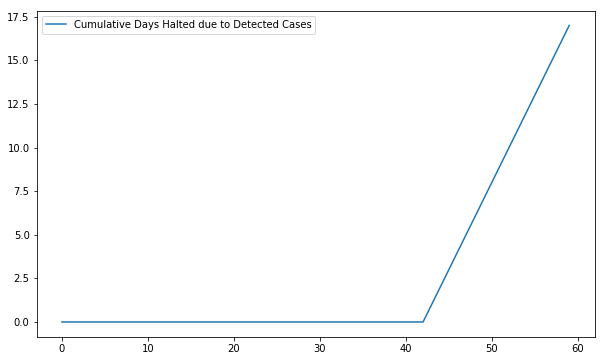

In [8]:
simulation = initiate_simulation()
run(simulation, number_of_days=60)
summarize(simulation)

In [9]:
test_latency = 2

Total number of tests performed over 60 days: 194


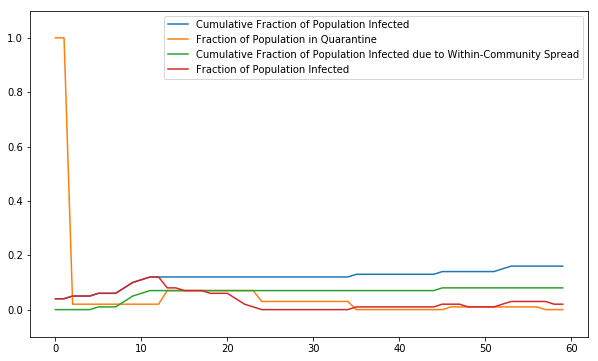

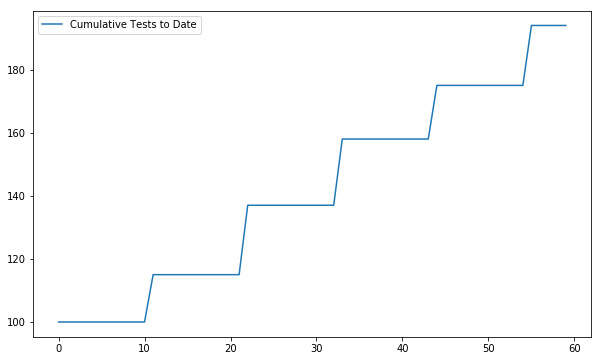

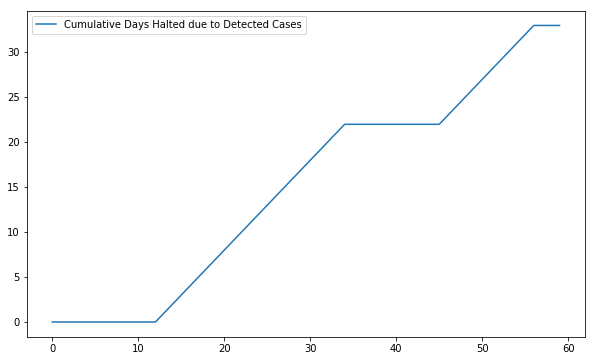

In [10]:
simulation = initiate_simulation()
run(simulation, number_of_days=60)
summarize(simulation)

In [11]:
test_day_frequency = 5

Total number of tests performed over 60 days: 332


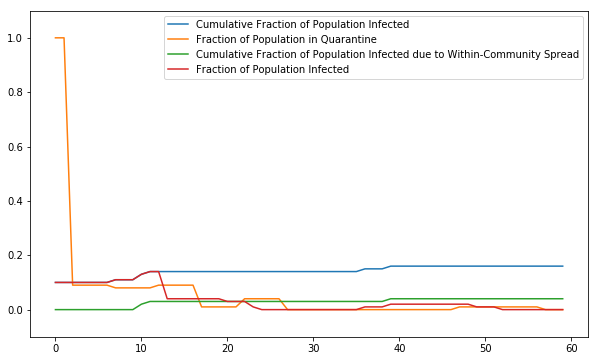

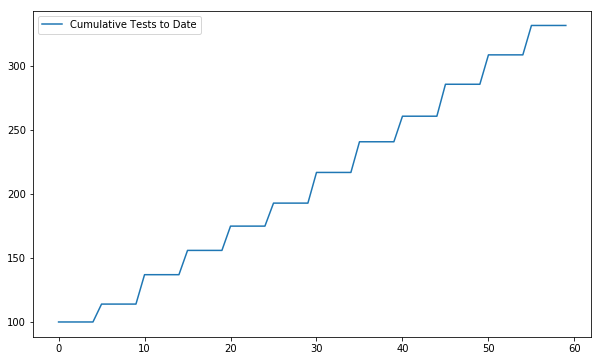

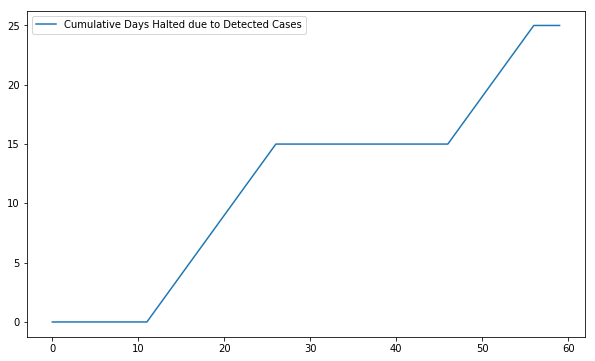

In [12]:
simulation = initiate_simulation()
run(simulation, number_of_days=60)
summarize(simulation)

In [8]:
outer_false_negative_rate = 0.1
inner_false_negative_rate = 0.01
group_test_participation_rate = 0.8

Total number of tests performed over 60 days: 174


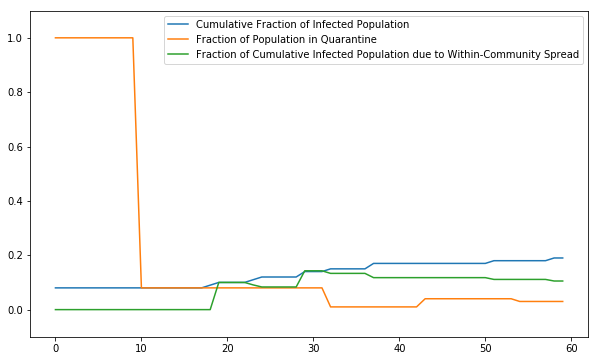

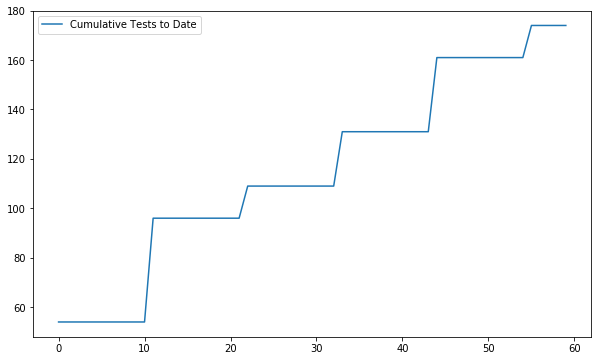

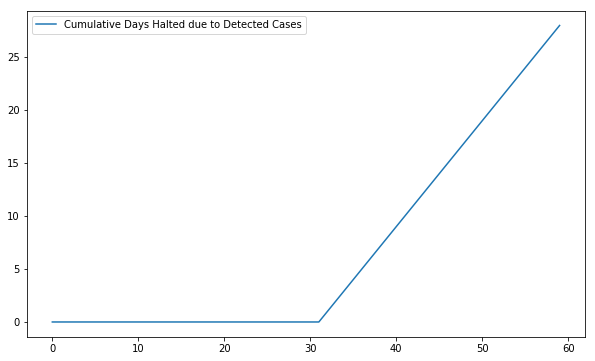

In [9]:
simulation = initiate_simulation()
run(simulation, number_of_days=60)
summarize(simulation)

In [15]:
group_test_participation_rate = 0.9

Total number of tests performed over 60 days: 279


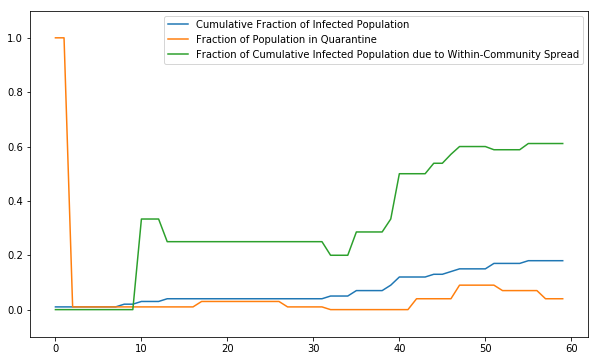

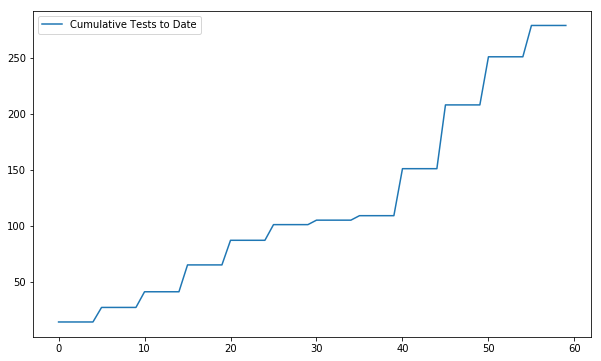

In [16]:
simulation = initiate_simulation()
run(simulation, number_of_days=60)
summarize(simulation)

In [19]:
outer_false_negative_rate = 0.01
inner_false_negative_rate = 0.01

Total number of tests performed over 60 days: 182


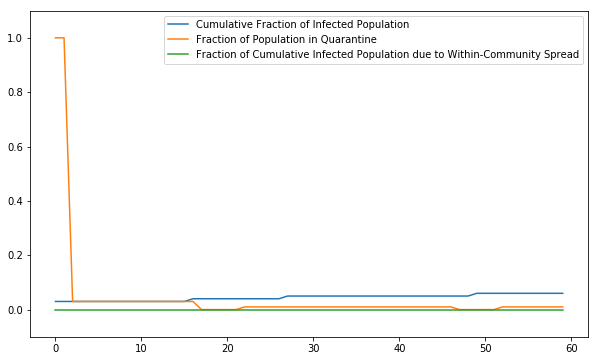

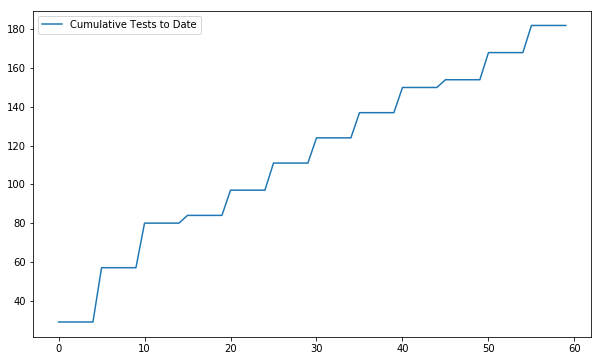

In [20]:
simulation = initiate_simulation()
run(simulation, number_of_days=60)
summarize(simulation)